##### [sample solution, trained for a few hours (not converged)]

# This tutorial is will bring you through your first deep reinforcement learning model


* Seaquest game as an example
* Training a simple lasagne neural network for Q_learning objective


## About OpenAI Gym

* Its a recently published platform that basicly allows you to train agents in a wide variety of environments with near-identical interface.
* This is twice as awesome since now we don't need to write a new wrapper for every game
* Go check it out!
  * Blog post - https://openai.com/blog/openai-gym-beta/
  * Github - https://github.com/openai/gym


## New to Lasagne and AgentNet?
* We only require surface level knowledge of theano and lasagne, so you can just learn them as you go.
* Alternatively, you can find Lasagne tutorials here:
 * Official mnist example: http://lasagne.readthedocs.io/en/latest/user/tutorial.html
 * From scratch: https://github.com/ddtm/dl-course/tree/master/Seminar4
 * From theano: https://github.com/craffel/Lasagne-tutorial/blob/master/examples/tutorial.ipynb
* This is pretty much the basic tutorial for AgentNet, so it's okay not to know it.


In [1]:
%load_ext autoreload
%autoreload 2

# Experiment setup
* Here we basically just load the game and check that it works

In [2]:
from __future__ import print_function 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%env THEANO_FLAGS="floatX=float32"

env: THEANO_FLAGS="floatX=float32"


In [4]:
#global params.
GAME = "LunarLanderContinuous-v2"

#number of parallel agents and batch sequence length (frames)
N_AGENTS = 1
SEQ_LENGTH = 10

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym
env = gym.make(GAME)
env.reset()
obs = env.step(env.action_space.sample())[0]
state_size = len(obs)
print(obs.shape)

[2016-12-14 02:38:12,878] Making new env: LunarLanderContinuous-v2


(8,)


In [6]:
env.action_space.low,env.action_space.high,

(array([-1., -1.]), array([ 1.,  1.]))

# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using shallow neural network.


In [8]:
import lasagne
from lasagne.layers import InputLayer,DenseLayer,batch_norm,dropout,NonlinearityLayer,GaussianNoiseLayer,ElemwiseSumLayer
import theano.tensor as T
#image observation at current tick goes here, shape = (sample_i,x,y,color)
observation_layer = InputLayer((None,state_size))

dense0 = DenseLayer(observation_layer,256,name='dense1')
dense1 = DenseLayer(dense0,256,name='dense2',nonlinearity=T.tanh,)

nn = dense1

In [9]:
#a layer that predicts Qvalues
from agentnet.learning.qlearning_naf import LowerTriangularLayer,NAFLayer
import theano
epsilon = theano.shared(np.float32(0.0))
n_actions = env.action_space.shape[0]
low = env.action_space.low
high = env.action_space.high

class naf:
    #predict mean
    mean = DenseLayer(nn,n_actions,nonlinearity=None,name='mu')
    
    action = NonlinearityLayer(mean,lambda a: a.clip(low,high))
    #add exploration (noize)
    action = GaussianNoiseLayer(action,sigma=epsilon)
    #clip back to action range
    action = NonlinearityLayer(action,lambda a: a.clip(low,high))
    
    #state value (for optimal action)
    V_layer = DenseLayer(nn,1,nonlinearity=None,name='V')
    
    #lower triangular matrix that describes "variance" term in NAF
    L_layer = LowerTriangularLayer(nn,n_actions,name='L')
    
    #advantage term [negative]
    A_layer = NAFLayer(action,mean,L_layer)
    
    #Q = V + A = optimal_value + negative_penalty_for_diverging_from_mean
    qvalues_layer = ElemwiseSumLayer([V_layer,A_layer])
    
    

##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [10]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=[naf.qvalues_layer,naf.V_layer,naf.L_layer,naf.mean],
              action_layers=naf.action)


In [11]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(naf.qvalues_layer,trainable=True)
weights

[dense1.W,
 dense1.b,
 dense2.W,
 dense2.b,
 V.W,
 V.b,
 mu.W,
 mu.b,
 L.preprocess_input.W,
 L.preprocess_input.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [12]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent,GAME, N_AGENTS,max_size=10000)


[2016-12-14 02:38:37,524] Making new env: LunarLanderContinuous-v2


In [13]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(10)


print(action_log)
print(reward_log)

[[[ 0.03422687  0.22225321]
  [ 0.07668241 -0.00301102]
  [-0.21279974 -0.10377608]
  [-0.07751393 -0.107909  ]
  [ 0.02133946 -0.03888784]
  [ 0.11148803 -0.04626344]
  [ 0.02013578 -0.07525788]
  [-0.04302869 -0.02809524]
  [-0.12381561 -0.02354189]
  [ 0.20552675  0.08976637]]]
[[-0.78526392 -1.85882304  0.62372596  0.56684725 -1.0229405  -0.78501682
  -1.53121011  0.48440251  0.41025322  0.        ]]
CPU times: user 628 ms, sys: 20 ms, total: 648 ms
Wall time: 239 ms


In [14]:
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# Q-learning
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (Q-learning objective)

In [15]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100,replace=True)

_,_,_,_,(action_qvalues_seq,optimal_qvalues_seq,l_term,mu_term) = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)



In [16]:
#get reference Qvalues according to Qlearning algorithm
from agentnet.learning.qlearning_naf import get_elementwise_objective

#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2
elwise_mse_loss = get_elementwise_objective(action_qvalues_seq[:,:,0],
                                            optimal_qvalues_seq[:,:,0],
                                            replay.rewards,
                                            replay.is_alive,
                                            gamma_or_gammas=0.99,)

#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()
#add l2 regularizer
loss += lasagne.regularization.regularize_network_params(nn,lasagne.regularization.l2)*1e-5

In [17]:
# Compute weight updates
updates = lasagne.updates.adam(loss,weights)

In [18]:
#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

In [19]:
#for MountainCar-v0 evaluation session is cropped to 200 ticks
untrained_reward = pool.evaluate(save_path="./records",record_video=True)

[2016-12-14 02:39:05,834] Making new env: LunarLanderContinuous-v2
[2016-12-14 02:39:05,839] Clearing 2 monitor files from previous run (because force=True was provided)
[2016-12-14 02:39:05,841] Starting new video recorder writing to /root/test/continuous/records/openaigym.video.0.371974.video000000.mp4


Episode finished after 75 timesteps with reward=-199.433403439


[2016-12-14 02:39:08,982] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/test/continuous/records')


In [20]:
from IPython.display import HTML
#!TODO add url
video_path="records/openaigym.video.0.371974.video000000.mp4" #<-- paste link from previous cell starting from records

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))


# Training loop

In [21]:
#starting epoch
epoch_counter = 1
loss=train_step()


#full game rewards
rewards = {epoch_counter:untrained_reward}

In [22]:
#pre-fill pool
from tqdm import tqdm
for i in tqdm(range(1000)):
    pool.update(SEQ_LENGTH,append=True,)


100%|██████████| 1000/1000 [00:13<00:00, 75.46it/s]


In [ ]:
epsilon.set_value(0.1)
#the loop may take eons to finish.
#consider interrupting early.
for i in tqdm(range(10000)):    
    
    
    #train
    for i in range(10):
        pool.update(SEQ_LENGTH,append=True,)
        
    for i in range(10):
        loss = loss * 0.99 + train_step()*0.01
    
    
    
    if epoch_counter%100==0:
        #average reward per game tick in current experience replay pool
        pool_mean_reward = np.average(pool.experience_replay.rewards.get_value()[:,:-1],
                                      weights=pool.experience_replay.is_alive.get_value()[:,:-1])
        pool_size = pool.experience_replay.rewards.get_value().shape[0]
        print("iter=%i\tloss=%.3f\tepsilon=%.3f\treward/step=%.5f\tpool_size=%i"%(epoch_counter,
                                                                                  loss,
                                                                                  epsilon.get_value(),
                                                                                  pool_mean_reward,
                                                                                  pool_size))
        

    ##record current learning progress and show learning curves
    if epoch_counter%500 ==0:
        n_games = 10
        epsilon.set_value(0)
        rewards[epoch_counter] = pool.evaluate( record_video=False,n_games=n_games,verbose=False)
        print("Current score(mean over %i) = %.3f"%(n_games,np.mean(rewards[epoch_counter])))
        epsilon.set_value(0.1)
        
    #if you see sudden slowdowns after few thousand iterations, it means box2d issue is still not fixed
    #use this line to reset it time to time:
    #pool.envs[0] = gym.make(GAME)
    
    
    epoch_counter  +=1

    
# Time to drink some coffee!

  1%|          | 79/10000 [02:31<4:23:24,  1.59s/it]

iter=3800	loss=70.977	epsilon=0.100	reward/step=-1.02659	pool_size=10000


  2%|▏         | 179/10000 [04:27<1:23:21,  1.96it/s]

iter=3900	loss=50.060	epsilon=0.100	reward/step=-0.72148	pool_size=10000


  3%|▎         | 278/10000 [05:54<4:26:14,  1.64s/it][2016-12-14 04:21:23,804] Making new env: LunarLanderContinuous-v2
[2016-12-14 04:21:23,809] Clearing 2 monitor files from previous run (because force=True was provided)


iter=4000	loss=35.338	epsilon=0.100	reward/step=-0.56612	pool_size=10000


[2016-12-14 04:22:08,439] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/test/continuous/records')
  3%|▎         | 279/10000 [06:41<40:49:03, 15.12s/it]

Current score(mean over 10) = -165.513


  4%|▍         | 379/10000 [07:57<1:30:16,  1.78it/s]

iter=4100	loss=23.550	epsilon=0.100	reward/step=-0.44988	pool_size=10000


  5%|▍         | 479/10000 [08:57<1:14:25,  2.13it/s]

iter=4200	loss=31.976	epsilon=0.100	reward/step=-0.46752	pool_size=10000


  6%|▌         | 579/10000 [09:39<1:04:25,  2.44it/s]

iter=4300	loss=59.696	epsilon=0.100	reward/step=-0.77709	pool_size=10000


  7%|▋         | 679/10000 [10:21<1:02:01,  2.50it/s]

iter=4400	loss=95.235	epsilon=0.100	reward/step=-1.22547	pool_size=10000


  8%|▊         | 778/10000 [11:06<1:10:14,  2.19it/s][2016-12-14 04:26:34,682] Making new env: LunarLanderContinuous-v2
[2016-12-14 04:26:34,687] Clearing 2 monitor files from previous run (because force=True was provided)


iter=4500	loss=111.045	epsilon=0.100	reward/step=-1.45352	pool_size=10000


[2016-12-14 04:26:35,363] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/test/continuous/records')
  8%|▊         | 779/10000 [11:07<1:37:21,  1.58it/s]

Current score(mean over 10) = -534.874


  9%|▉         | 879/10000 [11:48<1:05:05,  2.34it/s]

iter=4600	loss=145.347	epsilon=0.100	reward/step=-1.69639	pool_size=10000


 10%|▉         | 979/10000 [12:30<1:03:00,  2.39it/s]

iter=4700	loss=156.585	epsilon=0.100	reward/step=-1.88982	pool_size=10000


 11%|█         | 1079/10000 [13:14<57:12,  2.60it/s]

iter=4800	loss=177.128	epsilon=0.100	reward/step=-2.00173	pool_size=10000


 12%|█▏        | 1179/10000 [14:14<1:01:46,  2.38it/s]

iter=4900	loss=182.537	epsilon=0.100	reward/step=-2.07024	pool_size=10000


 13%|█▎        | 1278/10000 [15:08<2:22:02,  1.02it/s][2016-12-14 04:30:37,415] Making new env: LunarLanderContinuous-v2
[2016-12-14 04:30:37,419] Clearing 2 monitor files from previous run (because force=True was provided)


iter=5000	loss=207.330	epsilon=0.100	reward/step=-2.13864	pool_size=10000


[2016-12-14 04:30:40,263] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/test/continuous/records')
 13%|█▎        | 1279/10000 [15:12<4:29:12,  1.85s/it]

Current score(mean over 10) = -316.719


 14%|█▍        | 1379/10000 [16:01<1:09:17,  2.07it/s]

iter=5100	loss=198.018	epsilon=0.100	reward/step=-2.20260	pool_size=10000


 15%|█▍        | 1479/10000 [19:41<1:44:47,  1.36it/s]

iter=5200	loss=194.368	epsilon=0.100	reward/step=-2.09470	pool_size=10000


 16%|█▌        | 1579/10000 [20:41<1:31:52,  1.53it/s]

iter=5300	loss=163.186	epsilon=0.100	reward/step=-1.75315	pool_size=10000


 17%|█▋        | 1679/10000 [21:49<1:03:10,  2.20it/s]

iter=5400	loss=138.089	epsilon=0.100	reward/step=-1.33641	pool_size=10000


 18%|█▊        | 1778/10000 [23:07<1:14:06,  1.85it/s][2016-12-14 04:38:35,982] Making new env: LunarLanderContinuous-v2
[2016-12-14 04:38:35,987] Clearing 2 monitor files from previous run (because force=True was provided)


iter=5500	loss=121.250	epsilon=0.100	reward/step=-1.14887	pool_size=10000


[2016-12-14 04:38:40,534] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/test/continuous/records')
 18%|█▊        | 1779/10000 [23:13<4:34:51,  2.01s/it]

Current score(mean over 10) = -242.271


 19%|█▉        | 1879/10000 [24:31<1:04:57,  2.08it/s]

iter=5600	loss=102.322	epsilon=0.100	reward/step=-0.96360	pool_size=10000


 20%|█▉        | 1979/10000 [25:33<57:17,  2.33it/s]

iter=5700	loss=82.159	epsilon=0.100	reward/step=-0.86608	pool_size=10000


 21%|██        | 2079/10000 [26:25<54:35,  2.42it/s]

iter=5800	loss=83.814	epsilon=0.100	reward/step=-0.90250	pool_size=10000


 22%|██▏       | 2179/10000 [27:26<2:12:34,  1.02s/it]

iter=5900	loss=84.593	epsilon=0.100	reward/step=-0.93049	pool_size=10000


 23%|██▎       | 2278/10000 [28:24<1:29:24,  1.44it/s][2016-12-14 04:43:52,248] Making new env: LunarLanderContinuous-v2
[2016-12-14 04:43:52,252] Clearing 2 monitor files from previous run (because force=True was provided)


iter=6000	loss=81.875	epsilon=0.100	reward/step=-0.90980	pool_size=10000


[2016-12-14 04:43:55,603] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/test/continuous/records')
 23%|██▎       | 2279/10000 [28:28<3:41:00,  1.72s/it]

Current score(mean over 10) = -295.074


 24%|██▎       | 2350/10000 [29:18<1:04:23,  1.98it/s]

/root/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  app.launch_new_instance()


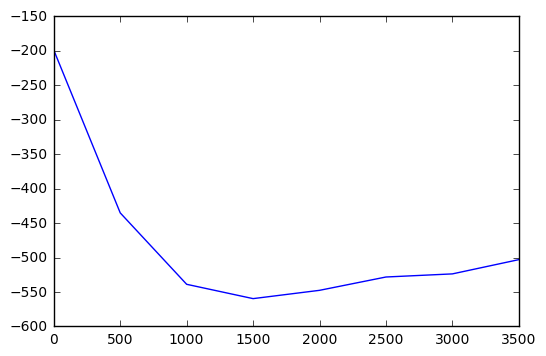

In [24]:
import pandas as pd
ticks,r = zip(*sorted(rewards.items(),key=lambda (k,v): k))
plt.plot(ticks,pd.ewma(np.array(map(np.mean,r)),alpha=0.1))

In [25]:
pool.evaluate(10)

[2016-12-14 04:12:23,454] Making new env: LunarLanderContinuous-v2
[2016-12-14 04:12:23,470] Clearing 2 monitor files from previous run (because force=True was provided)
[2016-12-14 04:12:23,476] Starting new video recorder writing to /root/test/continuous/records/openaigym.video.8.371974.video000000.mp4


Episode finished after 1000 timesteps with reward=-110.875128203


[2016-12-14 04:12:46,744] Starting new video recorder writing to /root/test/continuous/records/openaigym.video.8.371974.video000001.mp4


Episode finished after 1000 timesteps with reward=-99.9381066687
Episode finished after 1000 timesteps with reward=-99.010162853
Episode finished after 1000 timesteps with reward=-121.029896323
Episode finished after 1000 timesteps with reward=-82.7363235336
Episode finished after 1000 timesteps with reward=-100.427231227
Episode finished after 1000 timesteps with reward=-62.5335570436


[2016-12-14 04:14:01,278] Starting new video recorder writing to /root/test/continuous/records/openaigym.video.8.371974.video000008.mp4


Episode finished after 1000 timesteps with reward=-112.624933727
Episode finished after 1000 timesteps with reward=-90.5384471249


[2016-12-14 04:14:36,906] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/test/continuous/records')


Episode finished after 1000 timesteps with reward=-88.8171271279


[-110.87512820265022,
 -99.938106668678671,
 -99.010162853010826,
 -121.02989632301791,
 -82.736323533555364,
 -100.42723122660394,
 -62.533557043576607,
 -112.62493372678664,
 -90.538447124939253,
 -88.817127127869114]

In [ ]:
optimal_qvalues_seq.eval()